# M1: Primate Reach and Grasp 

M1 is a dataset originally collected to dissociate the effect of location and object in reach and grasp behaviors. This data has been previously discussed in [Rouse and Schieber 2015, J Neurophys](https://journals.physiology.org/doi/full/10.1152/jn.00686.2015), [Rouse and Schieber 2016, J Neurosci](https://www.jneurosci.org/content/36/41/10640?utm_source=TrendMD&utm_medium=cpc&utm_campaign=JNeurosci_TrendMD_0), [Rouse and Schieber 2016, J Neurophys](https://journals.physiology.org/doi/full/10.1152/jn.00008.2016),  and [Rouse and Schieber 2018, Cell Reports](https://doi.org/10.1016/j.celrep.2018.11.057).

The dataset contains neural activity of a rhesus monkey implanted with 6 floating microelectrode arrays (16 channels each, electrodes of length 1.5-8mm, see figure below from Rouse and Schieber 2016, J Neurosci for placement details). We focus on 4 of these arrays (H, I, J, and K) that were consistently recorded from throughout the duration of this dataset. In addition, intramuscular electromyography (EMG) is recorded from 16 locations of the right hand and upper extremity muscles, including: anterior deltoid (DLTa), posterior deltoid (DLTp), pectoralis major (PECmaj), short head of biceps (BCPs), lateral head of triceps (TCPlat), flexor carpi radialis (FCR), flexor carpi ulnaris (FCU), extensor carpi radialis brevis (ECRB), extensor carpi ulnaris (ECU), radial and ulnar flexor digitorum profundus (FDPr, FDPu), abductor pollicis longus (APL), extensor digitorum communis (EDC), thenar muscle group (Thenar), first dorsal interosseus (FDI), and hypothenar muscle group (Hypoth). 

![title](imgs/m1_neural.png)

# Task 

The monkey has been trained to reach to, grasp, and manipulate 4 different objects at 8 different locations, arranged in a center-out fashion. The 4 objects are separated by 45 degrees with a fifth object in the middle. The center object is a coaxial cylinder, and the four peripheral (target) objects include: a button mounted inside a tube, a sphere, a perpendicular cylinder, and a coaxial cylinder identical to the center object. The trained manipulation schemes are as follows: cylinders are pulled towards the subject, the button is pushed, and the sphere is rotated 45 degrees. 

The objects are arranged in a fixed order (perpendicular cylinder, coaxial cylinder, button, sphere) spanning 135 degrees of a circle. Objects were rotated to one of eight orientations in 22.5 degree increments [some positions excluded due to biomechanical or visual constraints]. This leads to a total of 8 possible locations per object. The figure below (adapted from Rouse and Schieber 2015, J Neurophys) demonstrates a number of possible orientations of the objects. 

Trials begin with the monkey pulling on the center cylinder and holding for 1500-2000ms. A blue light cues a pheripheral object, which the monkey needs to reach to, grasp, and manipulate. For a trial to be successful, the monkey complete these interactions with the cued object within 1000ms and hold the object in the manipulated state for 1000ms. 

![title](imgs/m1_behavior.png)

# Use in FALCON

This dataset provides four training datasets and four evaluation datasets. This task is important to the discussion of BCI stability as it focuses on EMG decoding, which tests a model's ability to predict many output variables. In addition, EMG decoding is relevant to BCI efforts to use functional electrical stimulation (FES) to stimulate a user's own limb to create movement.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pynwb import NWBHDF5IO
from data_demos.styleguide import set_style
set_style()

/tmp/ipykernel_507019/20793188.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_path = Path('./data/m1/sub-MonkeyL-held-in-calib/')
test_path = Path('./data/m1/sub-MonkeyL-held-out-calib/')

train_files = sorted(train_path.glob('*.nwb'))
test_files = sorted(test_path.glob('*.nwb'))

def get_start_date_and_volume(fn: Path):
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()
        start_date = nwbfile.session_start_time.strftime('%Y-%m-%d') # full datetime to just date
        raw_emg = nwbfile.acquisition['preprocessed_emg']
        muscles = [ts for ts in raw_emg.time_series]
        mdata = raw_emg.get_timeseries(muscles[0])
        timestamps = mdata.timestamps[:]

    return pd.to_datetime(start_date), timestamps.shape[0]

start_dates, volume = zip(*[get_start_date_and_volume(fn) for fn in train_files + test_files])
split_type = ['Held In'] * len(train_files) + ['Held Out'] * len(test_files) 

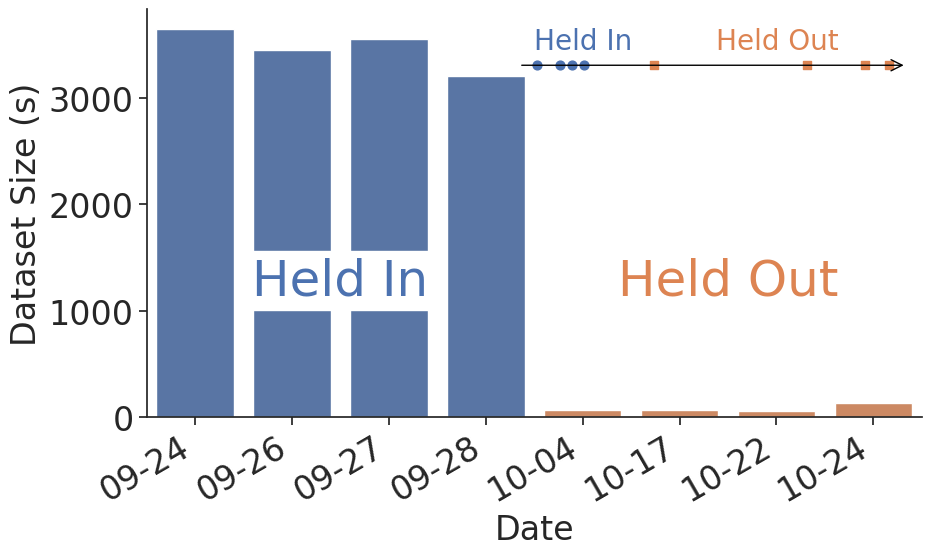

In [3]:
from visualization import plot_split_bars, plot_timeline

BIN_SIZE_S = 0.02
fig, ax = plt.subplots(figsize=(10, 6))

df = pd.DataFrame({'Date_Full': start_dates, 'Dataset Size': volume, 'Split Type': split_type})
# just get month and day
df['Dataset Size (s)'] = df['Dataset Size'] * BIN_SIZE_S
df['Date'] = df['Date_Full'].dt.strftime('%m-%d')

plot_split_bars(df, fig, ax)
sections = df.groupby(
    'Split Type'
)['Date'].apply(list).to_dict()
# sort section by section name, respect Train, Test Short, Test Long order
sections = {k: v for k, v in sorted(sections.items(), key=lambda item: item[1])}
plot_timeline(ax, sections)

# Quick Overview

The primary components of the dataset include recorded neural activity, EMG (which has been rectified and filtered), and trial metadata, such as start, go-cue, and stop times. 

Here we will visualize the experimental data. We will first load the NWB files, bin the spike times, and then plot the binned spikes and EMG.

In [4]:
from falcon_challenge.dataloaders import bin_units

def load_nwb(fn: str):
    print(f'Loading {fn}')
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()

        trial_info = (
            nwbfile.trials.to_dataframe()
            .reset_index()
            .rename({"id": "trial_id", "stop_time": "end_time"}, axis=1)
        )

        raw_emg = nwbfile.acquisition['preprocessed_emg']
        muscles = [ts for ts in raw_emg.time_series]
        emg_data = []
        emg_timestamps = []
        for m in muscles: 
            mdata = raw_emg.get_timeseries(m)
            data = mdata.data[:]
            timestamps = mdata.timestamps[:]
            emg_data.append(data)
            emg_timestamps.append(timestamps)

        emg_data = np.vstack(emg_data).T 
        emg_timestamps = emg_timestamps[0]

        units = nwbfile.units.to_dataframe()
        binned_units = bin_units(units, bin_size_s=0.02, bin_timestamps=emg_timestamps)

        eval_mask = nwbfile.acquisition['eval_mask'].data[:].astype(bool)

        return (
            binned_units,
            emg_data,
            emg_timestamps,
            muscles,
            trial_info,
            eval_mask
        )

spikes, emg, time, muscles, tinfo, eval_mask = load_nwb(train_files[0])

Loading /snel/share/share/derived/rouse/RTG/NWB_FALCON_v7_unsorted/held_in_calib/L_20120924_held_in_calib.nwb


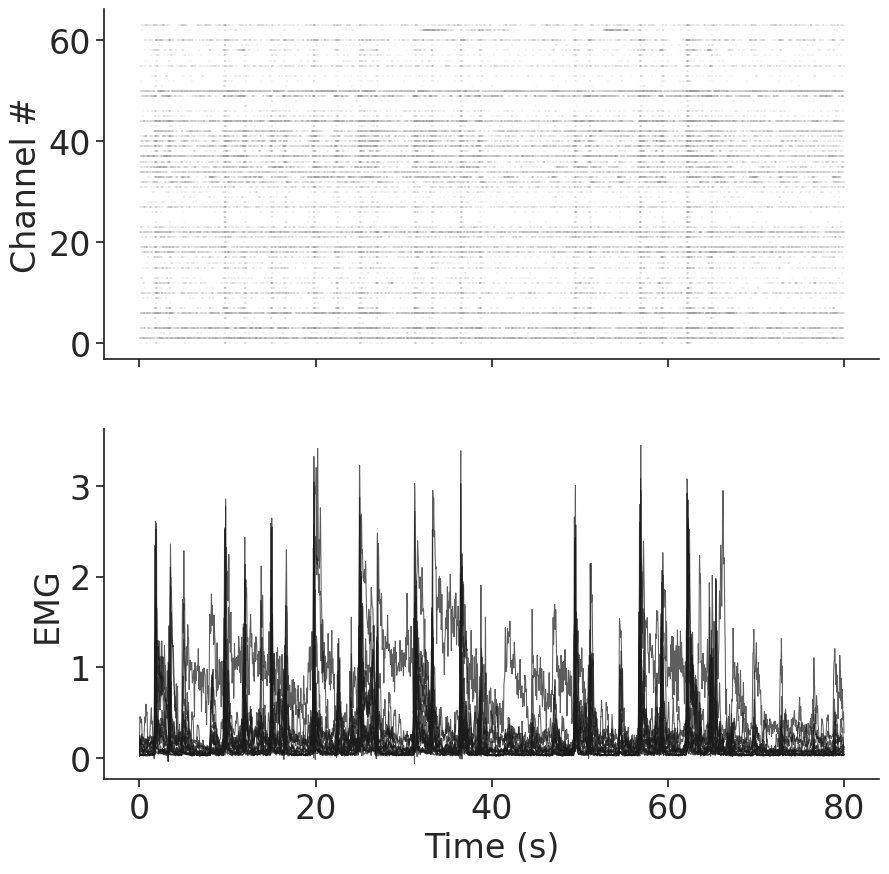

In [5]:
# %% plot some continuous raster/EMG data for a single session
from visualization import rasterplot

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=False)
rasterplot(spikes[:4001, :], bin_size_s=BIN_SIZE_S, ax=ax[0])
ax[1].plot(time[:4001], emg[:4001, :], linewidth=0.75, color='k', alpha=0.7)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('EMG')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.show()

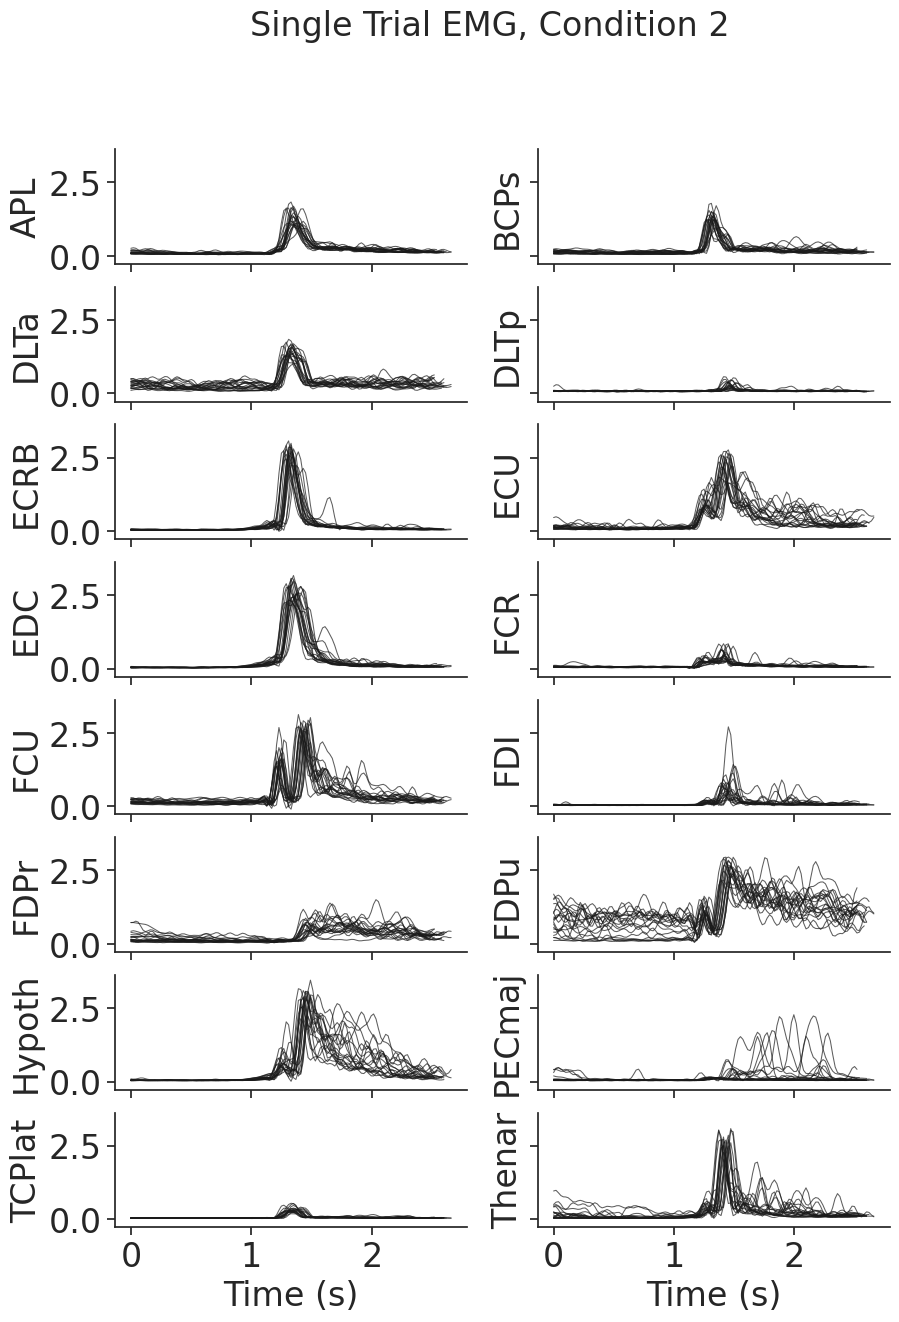

In [6]:
# some trialized EMG separated by muscle for a single session

cond = 2

condition_trials = tinfo.loc[tinfo['condition_id'] == cond]
fig, ax = plt.subplots(len(muscles)//2, 2, figsize=(10, 14), sharex=True, sharey=True)
axs = ax.flatten()

resamp_time = np.arange(0, time[-1], 0.02)

for trial in range(condition_trials.shape[0]):
    tr = condition_trials.iloc[trial] 
    # get the timestamps between start and stop time 
    start = tr['start_time']
    stop = tr['end_time']
    
    start_idx = np.where((resamp_time >= start - 0.01) & (resamp_time <= start + 0.01))[0][0]
    stop_idx = np.where((resamp_time >= stop - 0.01) & (resamp_time <= stop + 0.01))[0][0]
    for i, muscle in enumerate(muscles):
        signal = emg[start_idx:stop_idx, i]
        t = np.linspace(0, stop-start, len(signal))
        axs[i].plot(t, signal, label=muscle, alpha=0.7, linewidth=0.75, color='k')
        axs[i].set_ylabel(muscle)

ax[-1, 0].set_xlabel('Time (s)')
ax[-1, 1].set_xlabel('Time (s)')
plt.suptitle(f'Single Trial EMG, Condition {cond}')
plt.show()

# Neural activity statistics change over time 

The neural activity in these datasets consist of multiunit threshold crossings, putatively attributed to nearby spiking activity.

The statistics of neural activity are stable over the course of a single calibration period, but can be quite unstable over the course of multiple days. We see that simply by plotting the raw neural activity from consecutive days together. Instabilities can for example be attributed by given channels being more or less active on a given day, even though these channels _provide decoding signal_ on that day.

In [7]:
# load each day's data 
binned_neural = {}
emg_per_day = {}
metadata = {}
lengths = {}
times = {}
masks = {}

for f in train_files + test_files: 
    spikes, emg, time, muscles, tinfo, eval_mask = load_nwb(f)
    key = f.name.split('_')[1]
    binned_neural[key] = spikes
    lengths[key] = spikes.shape[0]
    emg_per_day[key] = emg 
    metadata[key] = tinfo
    times[key] = time
    masks[key] = eval_mask

Loading /snel/share/share/derived/rouse/RTG/NWB_FALCON_v7_unsorted/held_in_calib/L_20120924_held_in_calib.nwb
Loading /snel/share/share/derived/rouse/RTG/NWB_FALCON_v7_unsorted/held_in_calib/L_20120926_held_in_calib.nwb
Loading /snel/share/share/derived/rouse/RTG/NWB_FALCON_v7_unsorted/held_in_calib/L_20120927_held_in_calib.nwb
Loading /snel/share/share/derived/rouse/RTG/NWB_FALCON_v7_unsorted/held_in_calib/L_20120928_held_in_calib.nwb
Loading /snel/share/share/derived/rouse/RTG/NWB_FALCON_v7_unsorted/held_out_calib/L_20121004_held_out_calib.nwb
Loading /snel/share/share/derived/rouse/RTG/NWB_FALCON_v7_unsorted/held_out_calib/L_20121017_held_out_calib.nwb
Loading /snel/share/share/derived/rouse/RTG/NWB_FALCON_v7_unsorted/held_out_calib/L_20121022_held_out_calib.nwb
Loading /snel/share/share/derived/rouse/RTG/NWB_FALCON_v7_unsorted/held_out_calib/L_20121024_held_out_calib.nwb


In [8]:
trim_binned_neural = []
ind_binned_neural = []

for bn in binned_neural:
    trim_binned_neural.append(binned_neural[bn][:4001, :])
    ind_binned_neural.append(binned_neural[bn])

trim_binned_neural = np.vstack(trim_binned_neural)

all_binned_neural = np.vstack(ind_binned_neural)

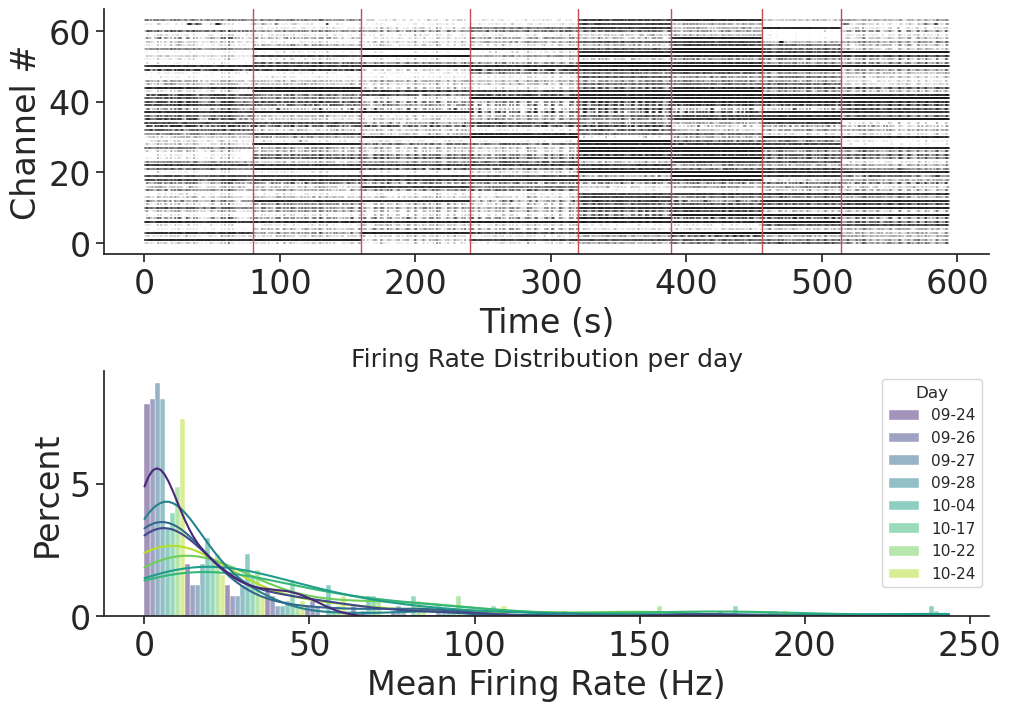

In [9]:
# Plot snippets of multiple days back to back to note change in structure
from visualization import plot_firing_rate_distributions 

f, axes = plt.subplots(2, 1, figsize=(10, 7), layout='constrained')

rasterplot(trim_binned_neural, ax=axes[0])
trim_lengths = [binned_neural[x][:4001, :].shape[0] for x in binned_neural]
day_intervals = np.cumsum(trim_lengths)

for i, length in enumerate(day_intervals[:-1]):
    axes[0].axvline(x = length * BIN_SIZE_S, color='r', linewidth=1)
axes[0].set_xlabel('Time (s)')

plot_firing_rate_distributions(lengths, all_binned_neural, start_dates, axes[1])

# Training and evaluating a linear decoder 

The FALCON benchmark measures decoding performance from neural data. Here we provide a basic linear decoder baseline to predict the EMG outputs. We evaluate this decoder only on periods during trials where we know what the monkey is supposed to be doing.

Note that we provide multiple days of training data. Decodability of different muscles varies across these days. Current practice prepares linear decoders using data from a single day. Linear decoders may or may not be able to exploit the multiple days of data - feel free to experiment!

In [10]:
# get smoothed spikes 
from preproc.filtering import apply_exponential_filter
smoothed_spikes = {}

for bn in binned_neural:
    smoothed_spikes[bn] = apply_exponential_filter(binned_neural[bn])

In [11]:
# TODO: Try different combinations of training datasets!
train_keys = ['20120924'] #, '20120926', '20120927', '20120928']

# Assuming smoothed_spikes and emg are 2D arrays with the same number of rows as time
concat_eval_mask = np.array(np.hstack([masks[k] for k in train_keys]))
concat_emg = np.concatenate([emg_per_day[k] for k in train_keys])
concat_spikes = np.concatenate([smoothed_spikes[k] for k in train_keys])
concat_times = np.concatenate([times[k] for k in train_keys])

emg_trials = concat_emg[concat_eval_mask]
smoothed_spikes_trials = concat_spikes[concat_eval_mask]
trial_times = concat_times[concat_eval_mask]

In [12]:
from decoder_demos.decoding_utils import (
    zscore_data,
    generate_lagged_matrix,
    apply_neural_behavioral_lag,
    fit_and_eval_decoder
)

# split into train and valid 
split_ind = int(0.8 * len(emg_trials))

smoothed_spikes_train, smoothed_spikes_valid = np.split(smoothed_spikes_trials, [split_ind])
emg_train, emg_valid = np.split(emg_trials, [split_ind])
time_train, time_valid = np.split(trial_times, [split_ind])

# train a decoder 
valid_score, decoder, y_pred = fit_and_eval_decoder(
    zscore_data(smoothed_spikes_train),
    emg_train,
    zscore_data(smoothed_spikes_valid),
    emg_valid,
    return_preds=True
)

# Print the score
print('Validation score:', valid_score) 

Validation score: 0.5134250426617485


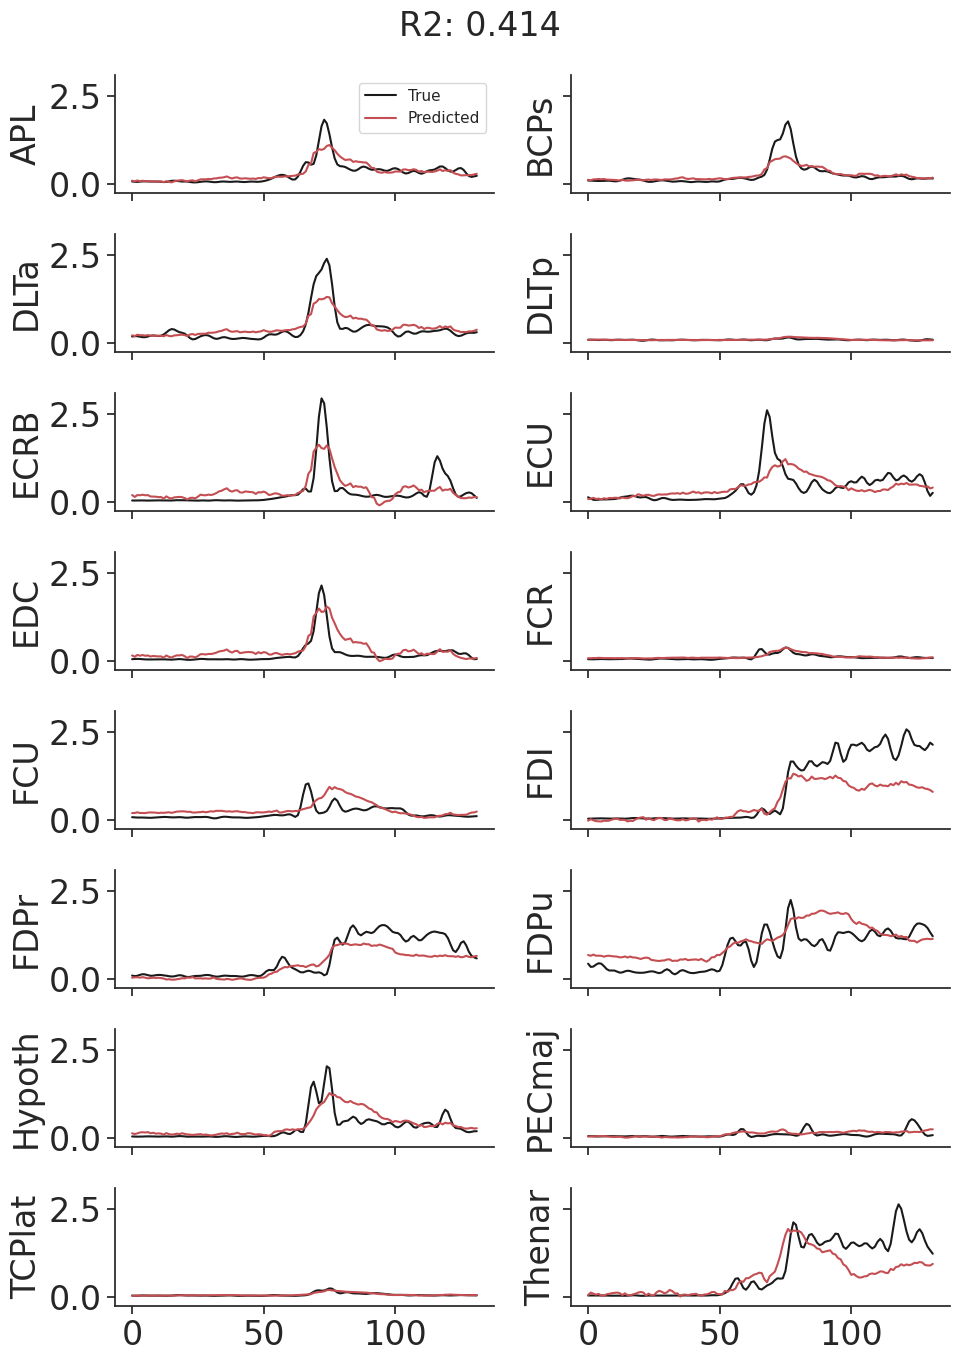

In [13]:
# plot an example trial from the validation data 
from sklearn.metrics import r2_score

time_train, time_valid = np.split(trial_times, [split_ind])
start_ind = np.searchsorted(time_valid, metadata[train_keys[-1]]['start_time'].iloc[-1])
end_ind = np.searchsorted(time_valid, metadata[train_keys[-1]]['end_time'].iloc[-1])
emg_trial = emg_valid[start_ind:end_ind, :]
pred_trial = y_pred[start_ind:end_ind, :]

num_dims = emg_trials.shape[1]

# Create a grid of subplots with num_dims rows and 1 column
fig, ax = plt.subplots(num_dims//2, 2, figsize=(10, 14), sharex=True, sharey=True)
axs = ax.flatten()

# Loop through each dimension
for i in range(num_dims):
    # Get the true and predicted data for the trial and dimension
    true_data = emg_trial[:, i]
    predicted_data = pred_trial[:, i]

    # Plot the data in the subplot
    axs[i].plot(true_data, label='True', color='k')
    axs[i].plot(predicted_data, label='Predicted', color='r')
    axs[i].set_ylabel(muscles[i])
    if i == 0:
        axs[i].legend()

plt.suptitle(f'R2: {np.around(r2_score(emg_trial, pred_trial), 3)}')
plt.tight_layout()
plt.show()

# Variations on a linear decoder

In motor tasks it is common to either incorporate historical data into the neural features (e.g., a Wiener Filter) or impose a lag on the neural data with respect to the behavior. Here we will demonstrate how those properties affect this dataset and how you may consider applying these utilities in your own methods.

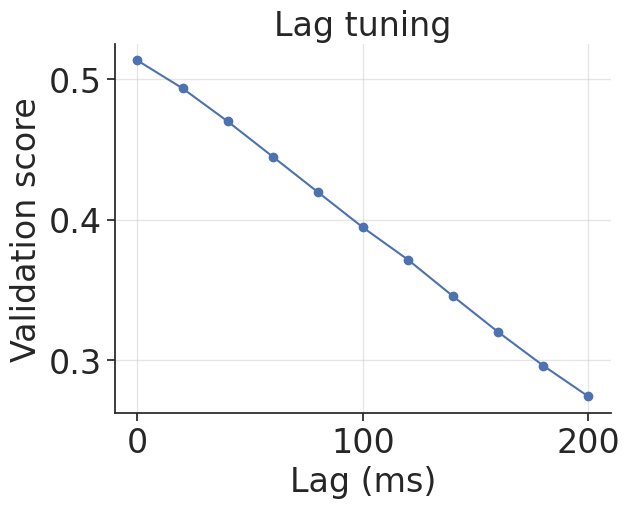

In [14]:
# checking if neural-behavioral lag improves decoding performance 

lag_ms = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
lag_scores = []

for lm in lag_ms: 
    lag_bins = int(lm / 20)
    lag_neural_train, lag_behavior_train = apply_neural_behavioral_lag(
        zscore_data(smoothed_spikes_train),
        emg_train,
        lag_bins
    )
    lag_neural_valid, lag_behavior_valid = apply_neural_behavioral_lag(
        zscore_data(smoothed_spikes_valid),
        emg_valid,
        lag_bins
    )
    valid_score, _ = fit_and_eval_decoder(
        lag_neural_train,
        lag_behavior_train,
        lag_neural_valid,
        lag_behavior_valid,
        return_preds=False
    )
    lag_scores.append(valid_score)

plt.figure()
plt.plot(lag_ms, lag_scores, marker='o')
plt.xlabel('Lag (ms)')
plt.ylabel('Validation score')
plt.title('Lag tuning')
plt.grid(alpha=0.5)

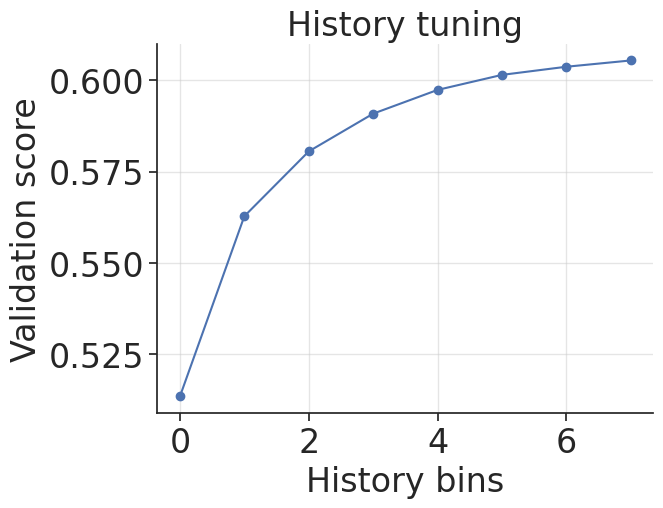

In [15]:
import warnings
warnings.filterwarnings("ignore")

history_bins = [0, 1, 2, 3, 4, 5, 6, 7]
history_scores = []

for hb in history_bins: 
    if hb > 0: 
        train_neural = generate_lagged_matrix(zscore_data(smoothed_spikes_train), hb)
        valid_neural = generate_lagged_matrix(zscore_data(smoothed_spikes_valid), hb)
        train_behavioral = emg_train[hb:]
        valid_behavioral = emg_valid[hb:]
    else:
        train_neural = zscore_data(smoothed_spikes_train)
        valid_neural = zscore_data(smoothed_spikes_valid)
        train_behavioral = emg_train
        valid_behavioral = emg_valid
    valid_score, _ = fit_and_eval_decoder(
        train_neural,
        train_behavioral,
        valid_neural,
        valid_behavioral,
        return_preds=False
    )
    history_scores.append(valid_score)

plt.figure()
plt.plot(history_bins, history_scores, marker='o')
plt.xlabel('History bins')
plt.ylabel('Validation score')
plt.title('History tuning')
plt.grid(alpha=0.5)

In [16]:
# move forward with best decoder 
import warnings
warnings.filterwarnings("ignore")

n_lag = 0
n_hist = 7

train_neural = generate_lagged_matrix(zscore_data(smoothed_spikes_train), n_hist)
valid_neural = generate_lagged_matrix(zscore_data(smoothed_spikes_valid), n_hist)
train_behavioral = emg_train[n_hist:]
valid_behavioral = emg_valid[n_hist:]

valid_score, decoder = fit_and_eval_decoder(
    train_neural,
    train_behavioral,
    valid_neural,
    valid_behavioral,
    return_preds=False
)

# Multi-day decoding 
FALCON evaluates decoder performance on novel days. Current decoders, including the simple linear decoder we train here, have greatly reduced performance when applied naively to new days. This issue is also a deeper change than surface level firing rate shifts. Real world performance thus requires advances in multi-day transfer, whether this comes from better base models, better calibration methods, or better test-time adaptation.

In [17]:
test_keys = ['20121004', '20121017', '20121022', '20121024']

performance = [valid_score]
for k in test_keys:
    smoothed_spikes_trials = generate_lagged_matrix(zscore_data(smoothed_spikes[k][masks[k]]), n_hist)
    emg_trials = emg_per_day[k][masks[k]][n_hist:]

    # Use the decoder to predict an output
    y_pred = decoder.predict(smoothed_spikes_trials)

    # Score the prediction using the corresponding example from emg_valid
    score = r2_score(emg_trials, y_pred, multioutput='variance_weighted')
    performance.append(score)
    
    # Print the average score
    print(f'{k} R^2:', score)

20121004 R^2: 0.47510805386149185
20121017 R^2: 0.3021149988404398
20121022 R^2: -0.052470140576670446
20121024 R^2: 0.1334395646660869


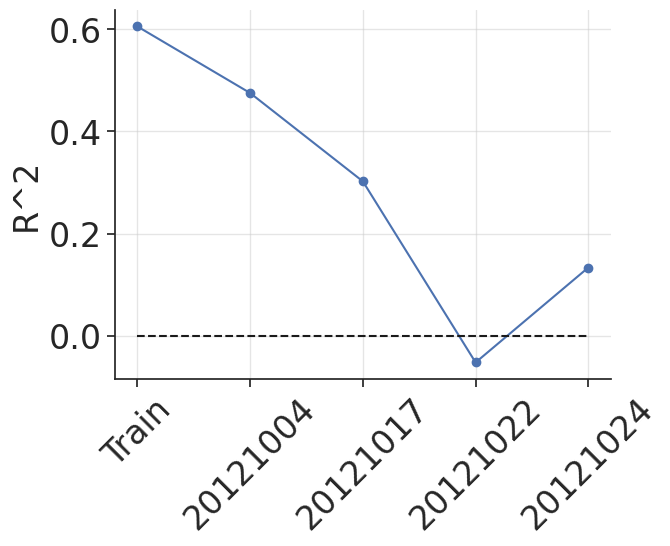

In [18]:
plt.figure()
plt.plot(performance, marker='o')
plt.xticks(range(5), ['Train'] + test_keys, rotation=45)
plt.hlines(0, 0, 4, linestyles='dashed', color='k')
plt.ylabel('R^2')
plt.grid(alpha=0.5)